# Detect fDOM Skyrockting Peaks

## Rules for Skyrocketing Peaks

Upward peak where: 
- Base width smaller than threshold 
- Prominence larger than a threshold 
- No adjacent upward peak in a certain range
- Both bases of the peak are not also fDOM downward peaks

## Import Tools, Load and Preprocess Data

In [1]:
# Import libraries and data 
import scipy.io as sio
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
import copy
import pickle
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import datetime
import csv
import math
import Tools.data_processing as dp
import Tools.data_movement as dm 
from Tools.auxiliary_functions import get_candidates, detect_flat_plat, detect_stage_rises

fDOM_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

## Get Candidate Peaks

In [2]:
prominence_range = [5,None]
width_range = [None,None]
wlen = 100
distance = 1
rel_height =.6

# Get list of all peaks that could possibly be plummeting peaks
peaks, props = find_peaks(fDOM_data[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance,
                          prominence = prominence_range,
                          width = width_range,
                          wlen = wlen,
                          rel_height = rel_height)

# Form candidate set from returned information
cands = [[peak, math.floor(props['left_ips'][i]), math.ceil(props['right_ips'][i]),props['prominences'][i]] for i,peak in enumerate(peaks)]

## Process proximity to other peaks in usable form

In [3]:
# Append some data to the end of cands that tell how far a peak is from other peaks (I think min of left and right should be fine)
# For each peak, determine how far it is from the closest adjacent peak
proximity_to_adjacent = np.zeros((len(peaks)))

for i in range(len(peaks)):
    x = y = fDOM_data.shape[0] + 1 
    if i > 0: 
        x = abs(peaks[i] - peaks[i-1])
    if i < len(peaks) - 1:
        y = abs(peaks[i] - peaks[i+1])
        
    proximity_to_adjacent[i] = min(x,y)


## Get Downward Peaks (used in detection mechanism) and process to usable form

In [4]:
# Flip timeseries 
flipped_fDOM = dp.flip_timeseries(copy.deepcopy(fDOM_data))

# Get fDOM plummeting peak candidate set using scipy find_peaks()
prominence_range = [3,None] # peaks must have at least prominence 3
width_range = [None,10] # peaks cannot have a base width of more than 5
wlen = 100 
distance = 1 
rel_height =.6

# Get list of all peaks that could possibly be plummeting peaks
downward_peaks, _ = find_peaks(flipped_fDOM[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance,
                          prominence = prominence_range,
                          width = width_range,
                          wlen = wlen,
                          rel_height = rel_height)

# Process into usable form: This is not efficient, but this operation is only peformed once... so no sweat 
proximity_to_downward = np.zeros((len(cands),2))

for i, cand in enumerate(cands): 
    x = y = fDOM_data.shape[0] + 1 
    
    for downward_peak in downward_peaks:
        if downward_peak <= cand[1]: 
            x = min(abs(cand[1]-downward_peak),x)
        elif downward_peak >= cand[2]:
            y = min(abs(cand[2]-downward_peak),y)
    proximity_to_downward[i,0] = x
    proximity_to_downward[i,1] = y

/var/folders/3w/lhkpgfc505n81_2vs8svxfpr0000gn/T/ipykernel_42338/2349065138.py:12: PeakPropertyWarning: some peaks have a prominence of 0
  downward_peaks, _ = find_peaks(flipped_fDOM[:,1],


## Import and process ground truths

In [5]:
# Import and process ground truth
truth_fname = 'Data/labeled_data/ground_truths/fDOM/fDOM_SKP/julian_time/fDOM_SKP_0k-300k.csv'

with open(truth_fname, 'r', newline = '') as f:
    
        reader = csv.reader(f, delimiter = ',')
        # truth entries in form: ['timestamp_of_peak', 'value_of_peak','label_of_peak','idx_of_peak']
        next(reader)
        truths = [[float(row[0]), float(row[1]), row[2], int(row[3])] for row in reader] 
        f.close()   

assert(len(truths) == len(cands))

## Define helper functions and set of training parameters, create training/testing splits

In [6]:
# Define Hyperparameter ranges and training parameters and helper function
iterations = 7000
num_splits = 5

basewidth_range = (1, 10)
prominence_range= (5, 20)

peak_proximity_bounds = (0,20)
downward_bases_range= (0,5) # sometimes the actual 'peak' of the downward peak is not exactly at the base of the skyrocketing peak 

accumulated_test_metrics = {}

accumulated_test_results = {}

accumulated_best_params = {}

accumulated_cfmxs = {}

train_test_split_indices = TimeSeriesSplit(num_splits).split(cands)

def classify_candidate_peaks(peaks, params):
    
    def check_downward_peak_condition(index):
        left = proximity_to_downward[index,0] <= params['downward_bases_threshold']
        right = proximity_to_downward[index,1] <= params['downward_bases_threshold']
    
        if left and right: return False
        if left and not right: return True 
        return True
        
    results = []
    for i,peak in enumerate(peaks):
        
        prominence_condition = peak[3] >= params['min_prominence']
        basewidth_condition = abs(peak[1] - peak[2]) <= params['max_basewidth']
        downward_bases_condition = check_downward_peak_condition(i)
        peak_proximity_condition = proximity_to_adjacent[i] >= params['proximity_threshold']
        
        if prominence_condition and basewidth_condition and downward_bases_condition and peak_proximity_condition:
            results.append([peak[0], 'SKP'])
        else:
            results.append([peak[0], 'NSKP'])
    return results

def label_positives_negatives(predictions, truths):
    TP = TN = FP = FN = 0
    results = []
    
    for i in range(len(predictions)):
        prediction = predictions[i][1]
        truth = truths[i][2]
        
        if prediction == 'SKP':
            if truth == 'NSKP':
                FP +=1
                results.append(predictions[i].append('FP'))
            else: 
                TP +=1
                results.append(predictions[i].append('TP'))
        else:
            if truth == 'NSKP':
                TN +=1
                results.append(predictions[i].append('TN'))
            else: 
                FN +=1
                results.append(predictions[i].append('FN'))
        
    return (TP,TN,FP,FN,results)
    

## Nested Cross Validation Training Loop

Num Pos in Test: 7
Num Pos in Train: 0

Num Pos in Test: 3
Num Pos in Train: 7

Split:  1
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 1  F1: 0.6667 BA: 0.8285  Params: {'max_basewidth': 3, 'min_prominence': 5.260161909702314, 'downward_bases_threshold': 4, 'proximity_threshold': 9}  TP: 2 TN: 102 FP: 1 FN: 1  Time: 0:00:01.449821
Num Pos in Test: 4
Num Pos in Train: 10

Split:  2
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 2  F1: 0.2500 BA: 0.6103  Params: {'max_basewidth': 3, 'min_prominence': 5.290710159207893, 'downward_bases_threshold': 2, 'proximity_threshold': 7}  TP: 1 TN: 99 FP: 3 FN: 3  Time: 0:00:02.137119
Num Pos in Test: 15
Num Pos in Train: 14

Split:  3
 700/7000  1400/7000  2100/7000  2800/7000  3500/7000  4200/7000  4900/7000  5600/7000  6300/7000 
Split: 3  F1: 0.4615 BA: 0.6725  Params: {'max_basewidth': 3, 'min_prominence': 5.288571759771007, 'd

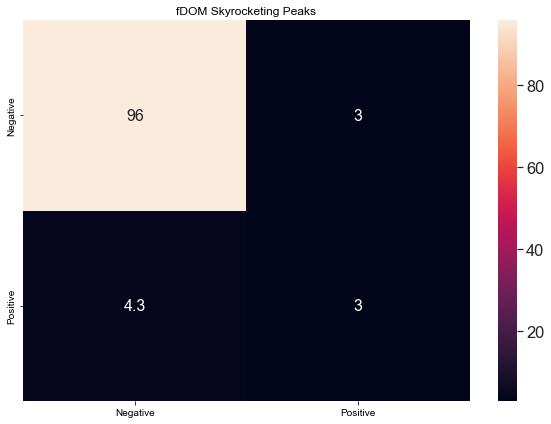

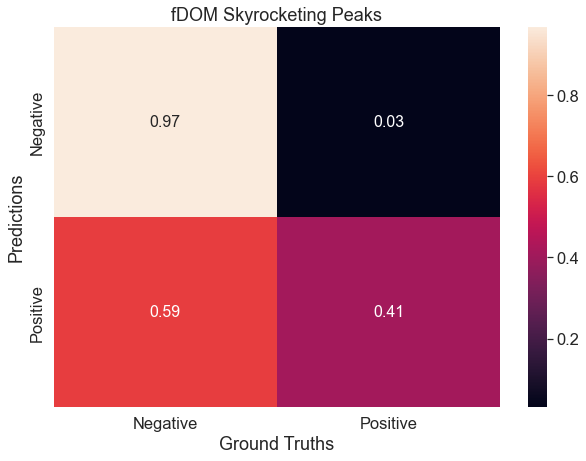

In [7]:
overall_start = datetime.datetime.now()

split = 1

for train_val_indices, test_indices in train_test_split_indices:
    X_train, y_train = [cands[i] for i in train_val_indices], [truths[i] for i in train_val_indices]
    X_test, y_test = [cands[i] for i in test_indices], [truths[i] for i in test_indices]
    
    num_pos_test= len(list(filter(lambda x: x[2] == "SKP", y_test)))
    num_pos_train= len(list(filter(lambda x: x[2] == "SKP", y_train)))
    
    print(f'Num Pos in Test: {num_pos_test}')
    print(f'Num Pos in Train: {num_pos_train}\n')

    if num_pos_test >= 1 and num_pos_train >= 1: 
    
        max_fold_metric = 0 
        max_result = None 

        print("Split: ",split)

        split_start = datetime.datetime.now()

        for iteration in range(iterations):

            # Random grid search for hyperparams 
            params = {}

            params['max_basewidth'] = np.random.randint(basewidth_range[0], basewidth_range[1]+1)
            params['min_prominence'] = np.random.uniform(prominence_range[0], prominence_range[1])

            params['downward_bases_threshold']= np.random.randint(downward_bases_range[0], downward_bases_range[1])

            params['proximity_threshold']= np.random.randint(peak_proximity_bounds[0], peak_proximity_bounds[1])

            predictions = classify_candidate_peaks(X_train, params)

            TP,TN,FP,FN,results = label_positives_negatives(predictions, y_train)

            TPR = 0 if TP == FN == 0 else TP/(TP + FN)
            TNR = TN/(TN + FP)

            bal_acc = (TPR + TNR)/2 

            f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

            acc = bal_acc
            if iteration and iteration % int(iterations/10) == 0: print(" {}/{} ".format(iteration, iterations), end = "")
            if acc > max_fold_metric: 
                max_fold_metric = acc
                max_result = copy.deepcopy(results)
                best_params = copy.deepcopy(params)

        # Test best parameters on testing data 
        test_predictions = classify_candidate_peaks(X_test, best_params)
        TP,TN,FP,FN,results = label_positives_negatives(test_predictions, y_test)

        cfmx = confusion_matrix([row[2] for row in y_test],[row[1] for row in test_predictions], labels = ['NSKP', 'SKP'])
        accumulated_cfmxs[split] = copy.deepcopy(cfmx)

        TPR = 0 if TP == FN == 0 else TP/(TP + FN)
        TNR = TN/(TN + FP)

        precision = 0 if TP == FP == 0 else TP/(TP + FP)

        bal_acc = (TPR + TNR)/2 

        f1_score = 0 if TP == FP == FN == 0 else (2 * TP)/((2 * TP) + FP + FN)

        print('\nSplit: {}  F1: {:.4f} BA: {:.4f}  Params: {}  TP: {} TN: {} FP: {} FN: {}  Time: {}'.format(split, f1_score, bal_acc, best_params, TP, TN, FP, FN, datetime.datetime.now() - split_start))
        accumulated_test_metrics[split] = {'f1': f1_score, 'ba' : bal_acc, 'tpr': TPR, 'tnr' : TNR, 'precision': precision} # Record test metrics of each split
        accumulated_test_results[split] = copy.deepcopy(results) # Record test results (FP,FN,TP,TN for each datapoint) for each split
        accumulated_best_params[split] = copy.deepcopy(best_params) # Record params uses in testing for each split

        split+=1

# Display Resuls 
mean_f1 = 0
mean_ba = 0 
mean_sensitivity = 0
mean_specificity = 0 
mean_precision = 0

for key in accumulated_test_metrics:
    metrics = accumulated_test_metrics[key]
    
    mean_f1+=metrics['f1']
    mean_ba+=metrics['ba']
    mean_sensitivity += metrics['tpr']
    mean_specificity += metrics['tnr']
    mean_precision += metrics['precision']

print("Mean Test F1: ", mean_f1/len(accumulated_test_metrics))
print("Mean Test BA: ", mean_ba/len(accumulated_test_metrics))
print("Mean Test TPR: ", mean_sensitivity/len(accumulated_test_metrics))
print("Mean Test TNR: ", mean_specificity/len(accumulated_test_metrics))
print("Mean Test Precision: ", mean_precision/len(accumulated_test_metrics))

print("Training time: ", datetime.datetime.now() - overall_start)

# Pickle best params
with open('Anomaly_Detection/Experimental_Results/fDOM_SKP/best_params.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_best_params, pck_file)
    pck_file.close()
    
# Pickle test results
with open('Anomaly_Detection/Experimental_Results/fDOM_SKP/test_results.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_results, pck_file)
    pck_file.close()

# Pickle test metrics
with open('Anomaly_Detection/Experimental_Results/fDOM_SKP/test_metrics.pkl', 'wb') as pck_file:
    pickle.dump(accumulated_test_metrics, pck_file)
    pck_file.close()


# Create and display confusion matrices
mean_cfmx = np.zeros((2,2))
for key in accumulated_cfmxs.keys():
    mean_cfmx += accumulated_cfmxs[key]
mean_cfmx = mean_cfmx / len(accumulated_cfmxs)



plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Skyrocketing Peaks')
sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx,index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})

plt.show()



plt.figure(figsize = (10,7))
plt.title(label = 'fDOM Skyrocketing Peaks')

sn.set(font_scale = 1.5)
sn.heatmap( pd.DataFrame(mean_cfmx.astype('float') / mean_cfmx.sum(axis=1)[:, np.newaxis],index = ['Negative', 'Positive'], columns = ['Negative','Positive']), annot = True, annot_kws ={"size": 16})
plt.xlabel('Ground Truths')
plt.ylabel('Predictions')
plt.show()


In [8]:
fDOM_cands = cands
s_indices = detect_stage_rises(stage_data[:,1])
turb_cand_params = {'prom' : [6,None],
                    'width': [None, None],
                    'wlen' : 200,
                    'dist' : 1,
                    'rel_h': .6}

# Get fDOM and turb candiate peaks
turb_peaks, turb_props = get_candidates(turb_data, turb_cand_params)

# Remove peaks that occur during a flat plateau 
turb_flat_plat = detect_flat_plat(turb_data, 100, 40)
turb_flat_plat_indxs = []
for i in range(turb_flat_plat.shape[0]):
    if turb_flat_plat[i] == 1:
        turb_flat_plat_indxs.append(i)

take_indices = []
for i,peak in enumerate(turb_peaks):
    if peak not in turb_flat_plat_indxs:
        take_indices.append(i)

turb_peaks = np.take(turb_peaks, take_indices)
for key in turb_props:
    turb_props[key] = np.take(turb_props[key], take_indices)

# Iterate through peaks and turn into short 3 point "events" by flagging the data point to either side of a peak
fDOM_events = []
fDOM_lb = []
fDOM_rb = []

for i,cand in enumerate(fDOM_cands):
            fDOM_events.append(np.array((fDOM_data[cand[0]])))
            fDOM_lb.append(fDOM_data[math.floor(cand[1]),0])
            fDOM_rb.append(fDOM_data[math.ceil(cand[2]),0])
            
fDOM_lb = list(set(fDOM_lb))
fDOM_lb.sort()
fDOM_rb = list(set(fDOM_rb))
fDOM_rb.sort()

turb_events = []
turb_lb = []
turb_rb = []
for i,peak in enumerate(turb_peaks):
            turb_events.append(np.array((turb_data[peak])))
            turb_lb.append(turb_data[math.floor(turb_props['left_ips'][i]),0])
            turb_rb.append(turb_data[math.ceil(turb_props['right_ips'][i]),0])
            
turb_lb = list(set(turb_lb))
turb_lb.sort()
turb_rb = list(set(turb_rb))
turb_rb.sort()            

fDOM_merged = dp.merge_data(fDOM_data, fDOM_events, 'not_sky_peak', '')
turb_merged = dp.merge_data(turb_data, turb_events, 't_opp', '')

fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_lb, 'left_base')
fDOM_merged = dp.merge_additional_data(fDOM_merged, fDOM_rb, 'right_base')

turb_merged = dp.merge_additional_data(turb_merged, turb_lb, 'left_base')
turb_merged = dp.merge_additional_data(turb_merged, turb_rb, 'right_base')


stage_edge_data = dp.stage_rises_to_data(s_indices, stage_data)
stage_data_merged = dp.merge_data(stage_data, stage_edge_data, 'rise','')

dm.write_data_to_trainset(fDOM_merged,
                          stage_data_merged,
                          turb_merged,
                          'Data/temp_plotting/fDOM_sky_0k-100k.csv',
                          True,
                          True,
                          0,
                          100000)